# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [2]:
# !pip install emoji_data_python

In [103]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [104]:
example_emoji.shape

(28, 28, 4)

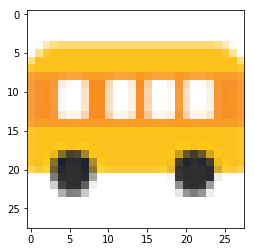

In [105]:
plt.imshow(example_emoji);

In [106]:
grayscale_emoji.shape

(28, 28)

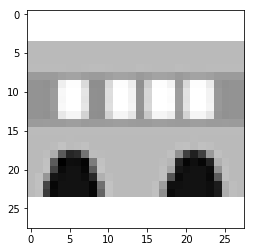

In [107]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

### Include transparency in the grayscale

In [157]:
from PIL import Image
from pathlib import Path

def png_drop_trans(png_path, output_dir):
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()
    try:
        im = Image.open(png_path)
        bg = Image.new("RGB", im.size, (255,255,255))
        bg.paste(im, im)
        bg.save(output_dir / png_path.name)
    except OSError as e:
        print(e)

In [ ]:
for png_path in Path('emoji').iterdir():
     png_drop_trans(png_path, output_dir='emoji_notrans')

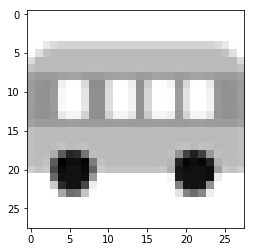

In [92]:
example_emoji = imageio.imread('emoji_notrans/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)
plt.imshow(grayscale_emoji, cmap="gray");

### Model and Train the GAN

In [163]:
import os
import numpy as np
from tqdm import tqdm  # performance timing

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

np.random.seed(10)
random_dim = 100

def load_emoji():
    images = []
    for path in Path('emoji_notrans').iterdir():
        example_emoji = imageio.imread(str(path))
        grayscale_emoji = color.rgb2gray(example_emoji).reshape(28 * 28)
        images.append(grayscale_emoji)

    images = np.vstack(images)
    
    return images


def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator


def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator


def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan


def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)


def train(epochs=1, batch_size=128, adam=None, generator=None, 
          discriminator=None, gan=None):
    # Get the training and testing data
    x_train = load_emoji()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
    
    return adam, generator, discriminator, gan

In [ ]:
adam, generator, discriminator, gan = train(80, 64)

--------------- Epoch 1 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  4.32it/s]


--------------- Epoch 2 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.81it/s]


--------------- Epoch 3 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.73it/s]


--------------- Epoch 4 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.01it/s]


--------------- Epoch 5 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.83it/s]


--------------- Epoch 6 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.74it/s]


--------------- Epoch 7 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.06it/s]


--------------- Epoch 8 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.00it/s]


--------------- Epoch 9 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.17it/s]


--------------- Epoch 10 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.88it/s]


--------------- Epoch 11 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.01it/s]


--------------- Epoch 12 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.13it/s]


--------------- Epoch 13 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.17it/s]


--------------- Epoch 14 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  6.01it/s]


--------------- Epoch 15 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  3.38it/s]


--------------- Epoch 16 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


--------------- Epoch 17 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.78it/s]


--------------- Epoch 18 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.25it/s]


--------------- Epoch 19 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


--------------- Epoch 20 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  6.43it/s]


--------------- Epoch 21 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


--------------- Epoch 22 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


--------------- Epoch 23 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.01it/s]


--------------- Epoch 24 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.05it/s]


--------------- Epoch 25 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


--------------- Epoch 26 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.14it/s]


--------------- Epoch 27 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.33it/s]


--------------- Epoch 28 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.39it/s]


--------------- Epoch 29 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


--------------- Epoch 30 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


--------------- Epoch 31 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


--------------- Epoch 32 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


--------------- Epoch 33 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


--------------- Epoch 34 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


--------------- Epoch 35 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


--------------- Epoch 36 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


--------------- Epoch 37 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.88it/s]


--------------- Epoch 38 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.17it/s]


--------------- Epoch 39 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.41it/s]


--------------- Epoch 40 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.32it/s]


--------------- Epoch 41 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.24it/s]


--------------- Epoch 42 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.45it/s]


--------------- Epoch 43 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.51it/s]


--------------- Epoch 44 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.61it/s]


--------------- Epoch 45 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.47it/s]


--------------- Epoch 46 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.75it/s]


--------------- Epoch 47 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.59it/s]


--------------- Epoch 48 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


--------------- Epoch 49 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.22it/s]


--------------- Epoch 50 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


--------------- Epoch 51 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.31it/s]


--------------- Epoch 52 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


--------------- Epoch 53 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.45it/s]


--------------- Epoch 54 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.30it/s]


--------------- Epoch 55 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.48it/s]


--------------- Epoch 56 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.20it/s]


--------------- Epoch 57 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.33it/s]


--------------- Epoch 58 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.74it/s]


--------------- Epoch 59 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.59it/s]


--------------- Epoch 60 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.73it/s]


--------------- Epoch 61 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.61it/s]


--------------- Epoch 62 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.38it/s]


--------------- Epoch 63 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.71it/s]


--------------- Epoch 64 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.51it/s]


--------------- Epoch 65 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


--------------- Epoch 66 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.96it/s]


--------------- Epoch 67 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.40it/s]


--------------- Epoch 68 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


--------------- Epoch 69 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


--------------- Epoch 70 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


--------------- Epoch 71 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


--------------- Epoch 72 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


--------------- Epoch 73 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


--------------- Epoch 74 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


--------------- Epoch 75 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.01it/s]


--------------- Epoch 76 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.21it/s]


--------------- Epoch 77 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


--------------- Epoch 78 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.44it/s]


--------------- Epoch 79 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.73it/s]


--------------- Epoch 80 ---------------


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.22it/s]


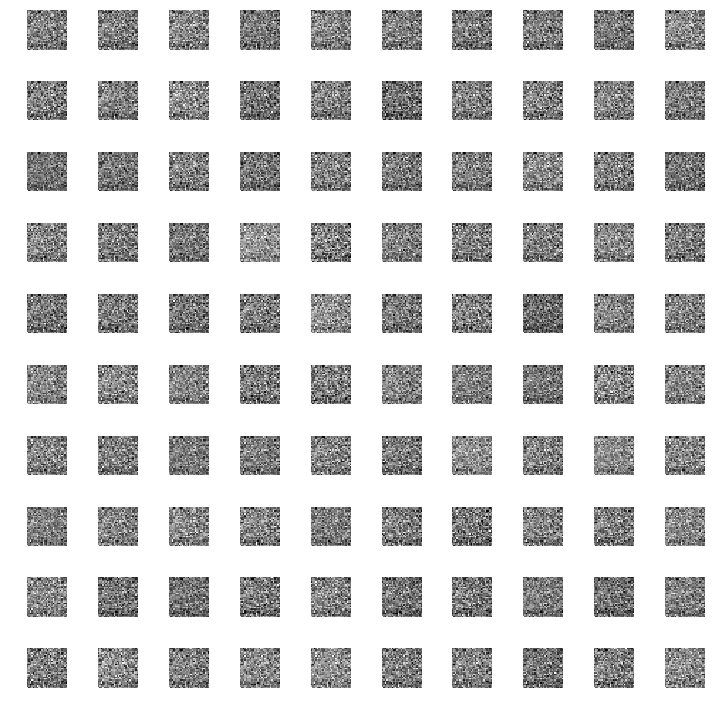

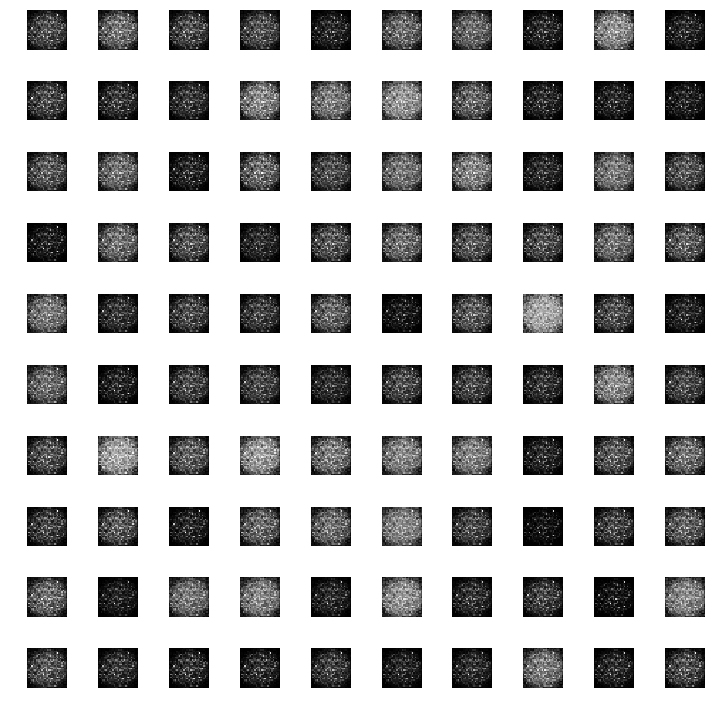

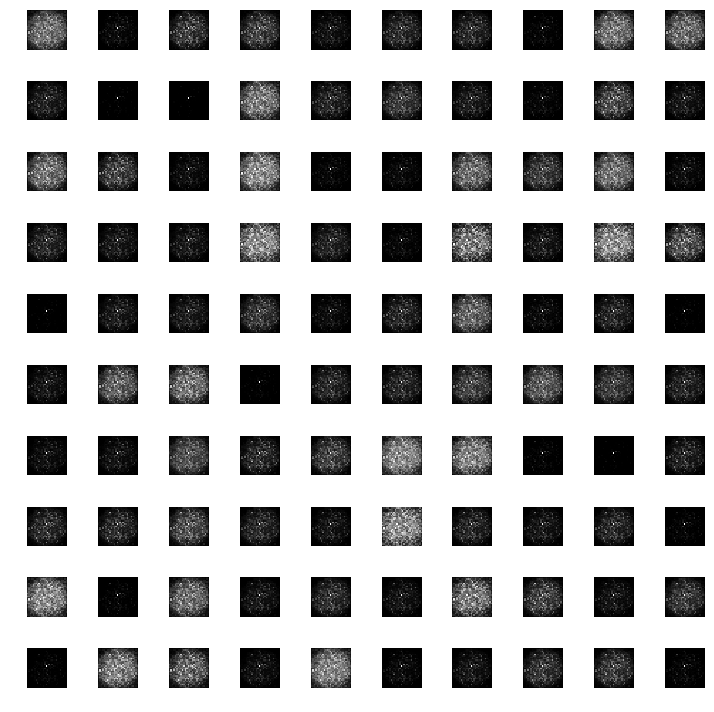

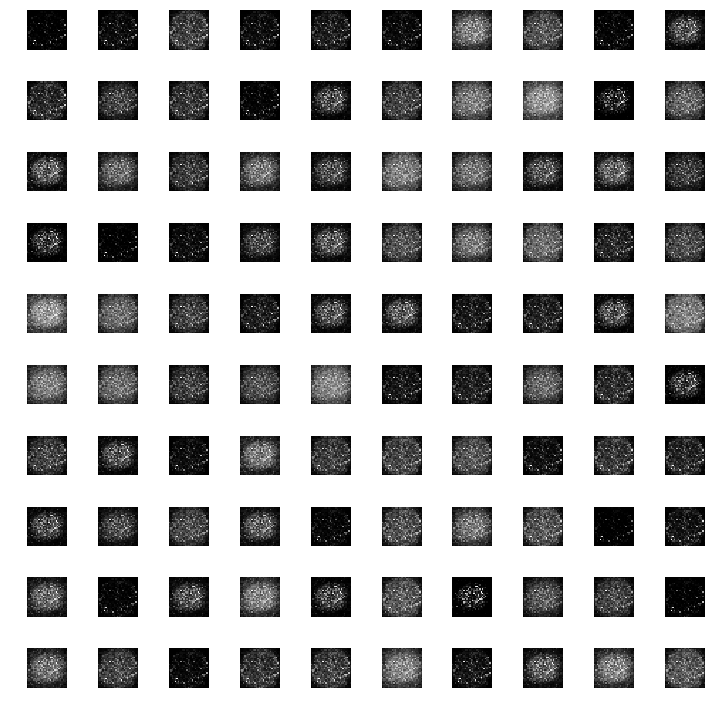

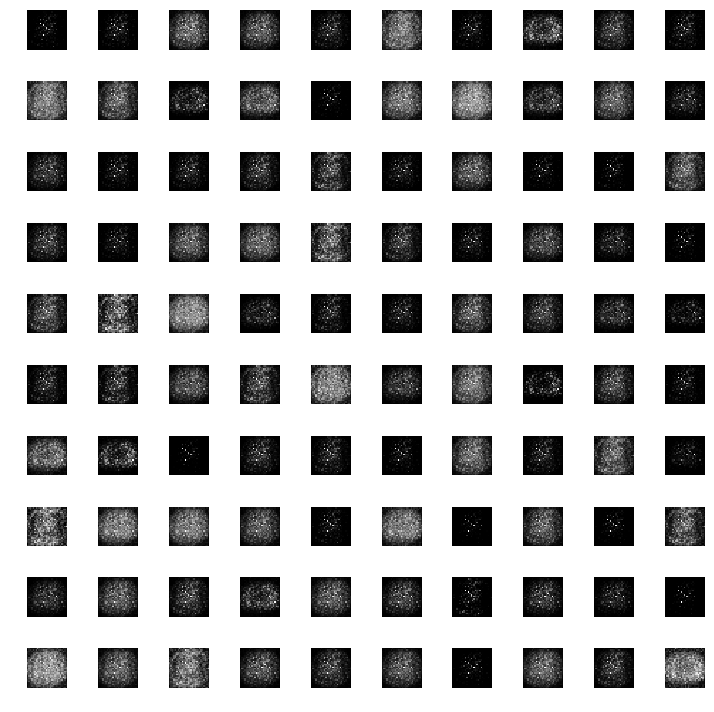

In [166]:
adam, generator, discriminator, gan = train(
    80, 64, adam, generator, discriminator, gan
)

#### Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)